# Visualización de conjuntos de datos de Stanford y Santa Maria
Roberto Araya Day

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import random
import os
from PIL import Image
from scipy.ndimage import zoom

/home/roberto/anaconda3/envs/lung_radiomics/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def show_slice_window(slice, level, window):

    """
    Permite ajustar nivel y ancho de ventana para mejorar contraste de la imagen.
    input: imagen np.array 2D.
    output: imagen np.array 2D ajustada.
   """
    max = level + window/2
    min = level - window/2
    return slice.clip(min,max)

def visualizeImgMask(img, mask, cmap_clr='gray'):
    """
    Función para visualizar las imágenes, máscaras y fusión.
    INPUT: imágenes y máscaras como numpy array 3D (numero de imagenes, alto, ancho),
    PET: True or False. Si es True se visualiza en inverso (cmap=gray_r),
    solo por un tema de convención de la visualización del PET.
    """
    img, mask = img.numpy(), mask.numpy()
    img, mask = ((img - np.min(img)) / (np.max(img) - np.min(img)) * 255).astype(np.uint8), (mask * 255).astype(np.uint8) # adjust scale
    img_pil, mask_pil = Image.fromarray(img), Image.fromarray(mask)

    f, axarr = plt.subplots(1, 3, figsize=(10, 10))
    axarr[0].set_title("Exam Image")
    axarr[0].imshow(img_pil, cmap=cmap_clr)
    axarr[1].set_title("Mask")
    axarr[1].imshow(mask_pil, cmap='Blues')
    axarr[2].set_title("Fusion")
    axarr[2].imshow(img_pil, cmap='gray')
    axarr[2].imshow(mask_pil, cmap='gnuplot', alpha=0.6)
    plt.show()

def roiExtractionResize(img_exam, mask_exam, img_size, margin=3):
    img_instance, mask_instance = img_exam.numpy(), mask_exam.numpy()
    index = np.where(mask_instance)

    # define coordinates
    x2 = np.unique(index[0])[-1]
    x1 = np.unique(index[0])[0]

    y2 = np.unique(index[1])[-1]
    y1 = np.unique(index[1])[0]

    # width and height
    width = x2 - x1
    height = y2 -y1

    if width > height:
        lmargin = (width-height)//2
        rmargin = width-lmargin
        x1 = x1 - lmargin
        x2 = x2 + rmargin

    else:
        tmargin = (height - width) // 2
        bmargin = height - tmargin
        y1 = y1 - tmargin
        y2 = y2 + bmargin

    
    roi = img_instance[x1-margin:x2+margin, y1-margin:y2+margin]
    print('shape roi:', roi.shape)
    
    # Convert NumPy array to Pillow Image
    roi_image = Image.fromarray(roi)

    # Resize the image to (img_size, img_size)
    roi_resized = roi_image.resize((img_size, img_size))

    # Convert back to NumPy array
    roi_resized_array = np.array(roi_resized)

    return roi_resized_array


def roiExtractionSize(img, mask, total_size=None, margin=3):
    """
    Function to extract ROIs from images while ensuring a consistent total size for all ROIs.

    INPUT:
    img: Numpy array of images.
    mask: Numpy array of masks.
    total_size: The desired total size (width and height) of the extracted ROIs.

    OUTPUT: Numpy array containing the ROIs.
    """
    
    img_instance, mask_instance = img.numpy(), mask.numpy()
    index = np.where(mask_instance)

    if total_size == None:
        roi = img_instance[np.unique(index[0])[0]-margin:np.unique(index[0])[-1]+margin, np.unique(index[1])[0]-margin: np.unique(index[1])[-1]+margin]
    else:
    
        # Calculate the center of the mask.
        center_row, center_col = int(np.mean(index[0])), int(np.mean(index[1]))
    
        # Calculate the size of the ROI based on the total size.
        half_size = total_size // 2
    
        # Determine ROI boundaries with the margin.
        min_row = max(0, center_row - half_size)
        max_row = min(mask_instance.shape[0], center_row + half_size)
        min_col = max(0, center_col - half_size)
        max_col = min(mask_instance.shape[1], center_col + half_size)
    
        # Calculate the width and height of the ROI.
        roi_height = max_row - min_row
        roi_width = max_col - min_col
    
        # Case 1: If the ROI is smaller than the total_size, add a margin to make it total_size.
        if roi_height < total_size:
            margin = (total_size - roi_height) // 2
            min_row -= margin
            max_row += margin
    
        if roi_width < total_size:
            margin = (total_size - roi_width) // 2
            min_col -= margin
            max_col += margin
    
        # Case 2: If the ROI is larger than total_size, resize it.
        if roi_height > total_size or roi_width > total_size:
            scale_factor = total_size / max(roi_height, roi_width)
            new_height = int(roi_height * scale_factor)
            new_width = int(roi_width * scale_factor)
            min_row = max(center_row - new_height // 2, 0)
            max_row = min(min_row + new_height, mask_instance.shape[0])
            min_col = max(center_col - new_width // 2, 0)
            max_col = min(min_col + new_width, mask_instance.shape[1])
    
        # Extract the ROI with the desired size.
        roi = img_instance[min_row:max_row, min_col:max_col]
    
    return roi


## Visualizar ejemplos multimodales

In [4]:
def visualize_n_samples(n_patients, n_samples, roiExtractionfn, body_ds, body_info, torax_ds, torax_info, pet_ds, pet_info, show_slice_fn=True):
    # Obtener las claves de los conjuntos de datos para cada modalidad
    body_keys, torax_keys, pet_keys = list(body_info.splits.keys()), list(torax_info.splits.keys()), list(pet_info.splits.keys())

    # Inicializar contadores
    patients_counter = 0

    # Iterar sobre las claves comunes a los tres conjuntos de datos
    for key in set(body_keys) & set(torax_keys) & set(pet_keys):
        patients_counter += 1
        # Obtener datos para cada modalidad del paciente actual
        body_data, torax_data, pet_data = body_ds[key], torax_ds[key], pet_ds[key]
        print("patient:", key)

        # Inicializar el contador de muestras
        samples_counter = 0

        # Iterar sobre las muestras de cada modalidad
        for body_sample, torax_sample, pet_sample in zip(body_data, torax_data, pet_data):
            samples_counter += 1

            # Crear una figura con subgráficos
            f, axarr = plt.subplots(2, 3, figsize=(10, 7))
            
            # Iterar sobre las modalidades y mostrar las imágenes y máscaras
            modalities = ["Body Exam", "Torax 3D Exam", "Pet Exam"]
            for i, (sample, title) in enumerate(zip([body_sample, torax_sample, pet_sample], modalities)):
                label = sample['label']
                axarr[0, i].set_title(f"{title} - Label {label}")
                cmap = 'gray_r' if sample is pet_sample else 'gray'
                axarr[0, i].imshow(sample['img_exam'], cmap=cmap)
                axarr[0, i].imshow(sample['mask_exam'], cmap='gnuplot', alpha=0.4)

            # Iterar sobre las modalidades y mostrar las imágenes con la máscara de la región de interés (ROI)
            for i, (sample, title) in enumerate(zip([body_sample, torax_sample, pet_sample], modalities)):
                label = sample['label']
                axarr[1, i].set_title(f"{title} ROI Mask")
                roi_img = roiExtractionfn(sample['img_exam'], sample['mask_exam'], 32)
                if (sample is body_sample or sample is torax_sample) and show_slice_fn: roi_img = show_slice_window(roi_img, 50, 100)
                cmap = 'gray_r' if sample is pet_sample else 'gray'
                axarr[1, i].imshow(roi_img, cmap=cmap)
            
            # Mostrar la figura con subgráficos
            plt.show()

            # Romper el bucle si se alcanza el número deseado de muestras
            if samples_counter >= n_samples:
                break
        
        # Romper el bucle si se alcanza el número deseado de pacientes
        if patients_counter >= n_patients:
            break


patient: sm_020


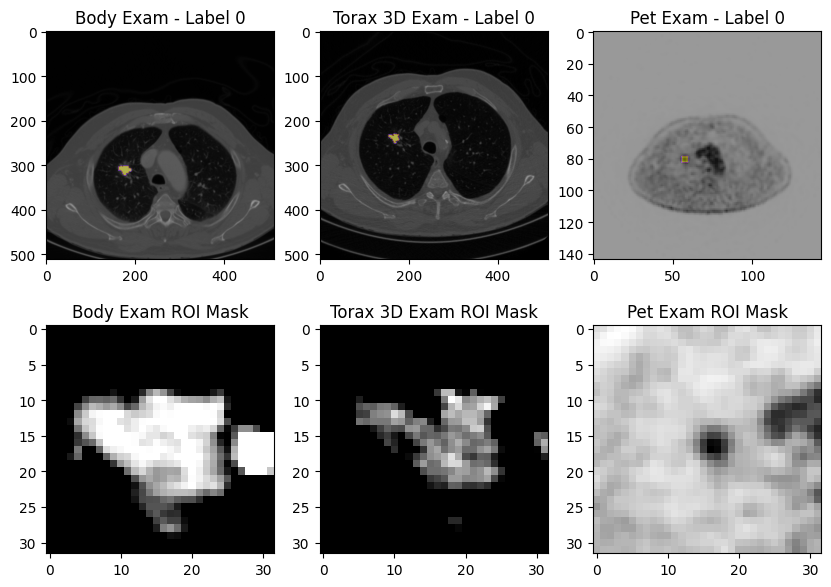

patient: sm_012


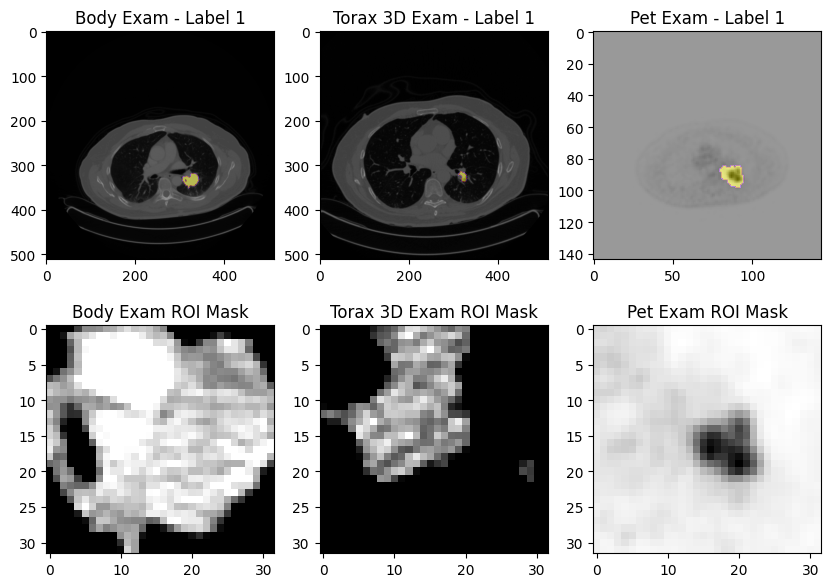

patient: sm_005


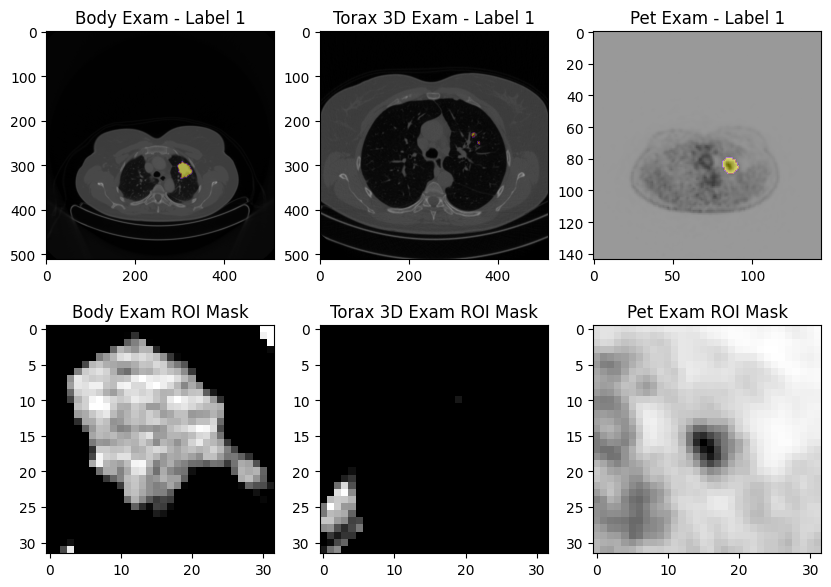

patient: sm_021


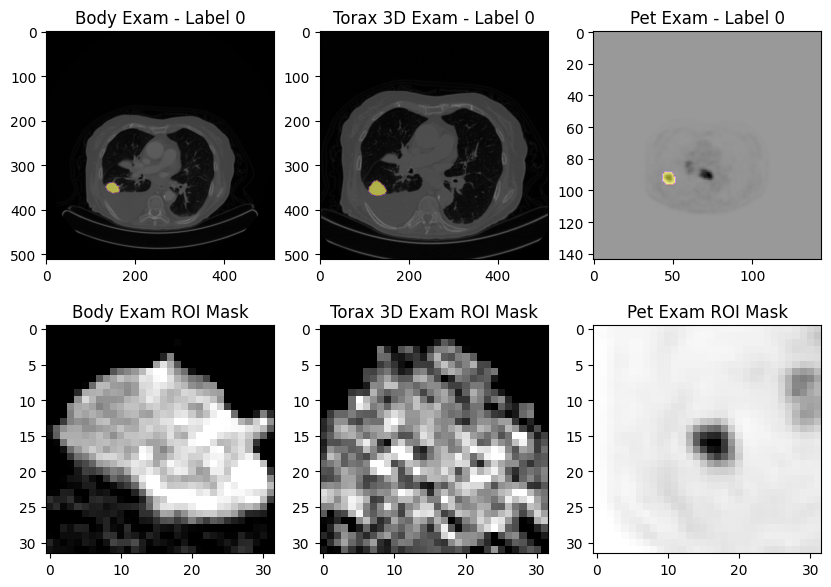

patient: sm_029


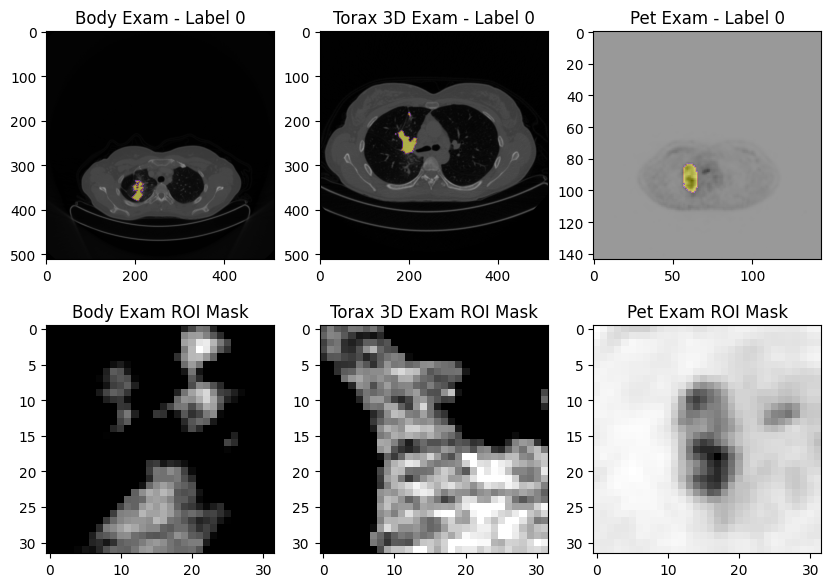

patient: sm_034


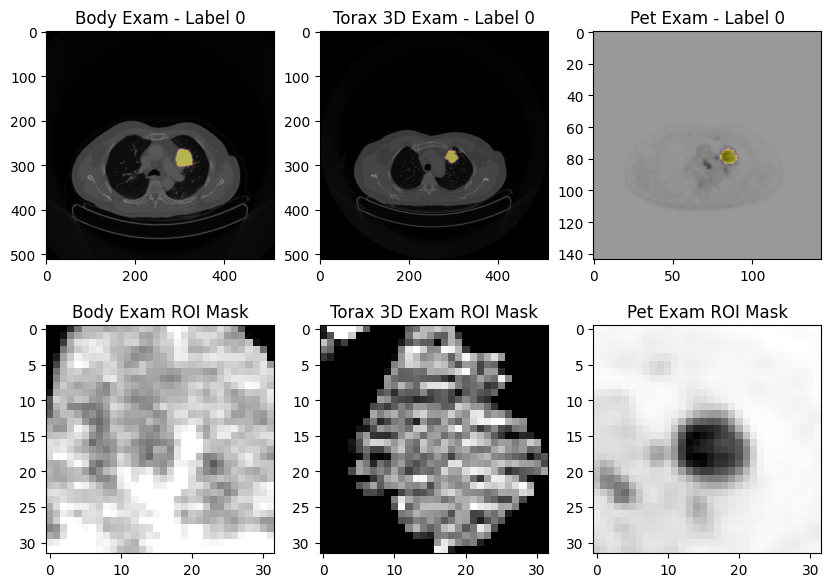

patient: sm_018


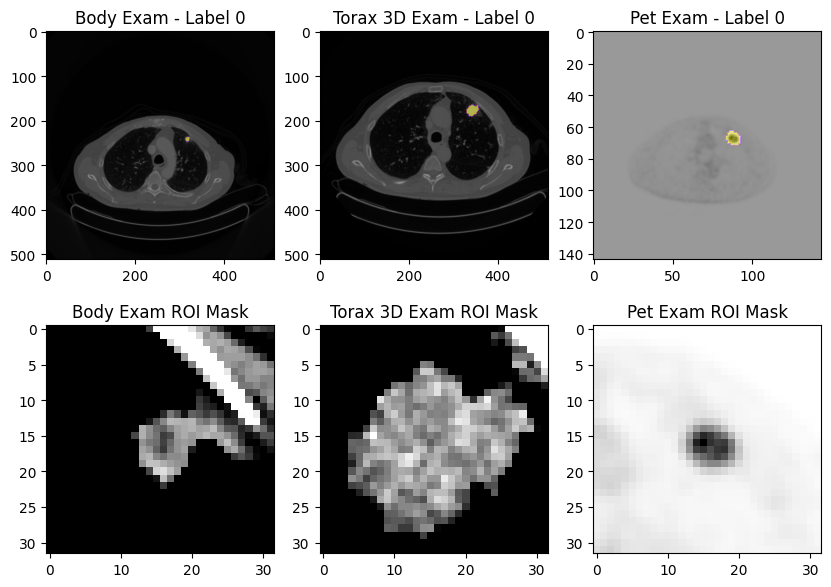

patient: sm_025


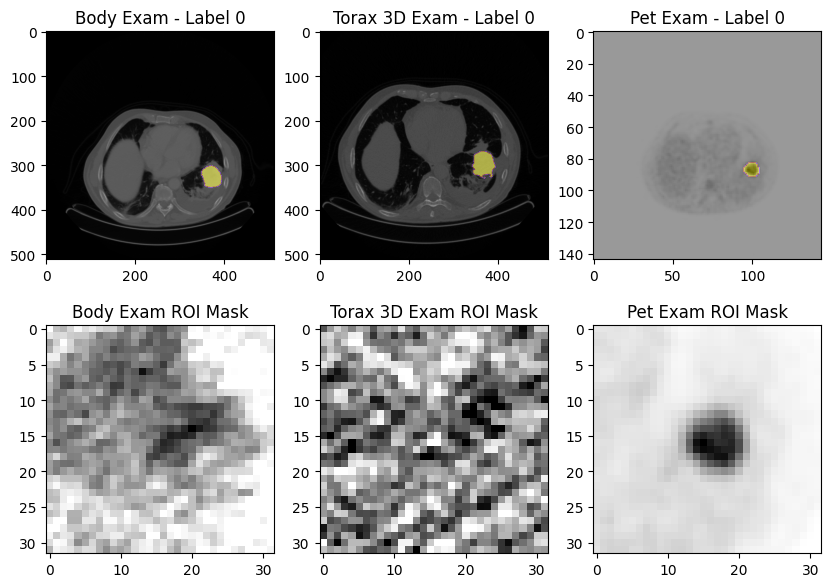

patient: sm_001


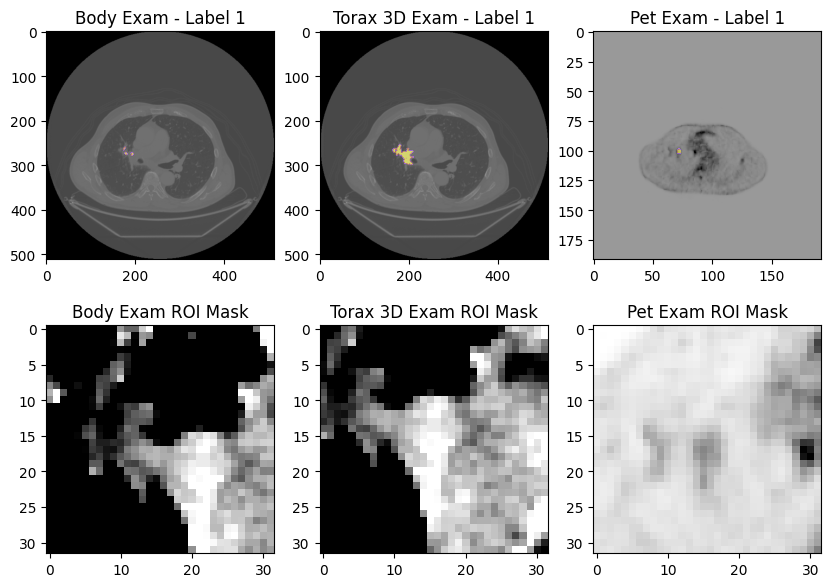

patient: sm_017


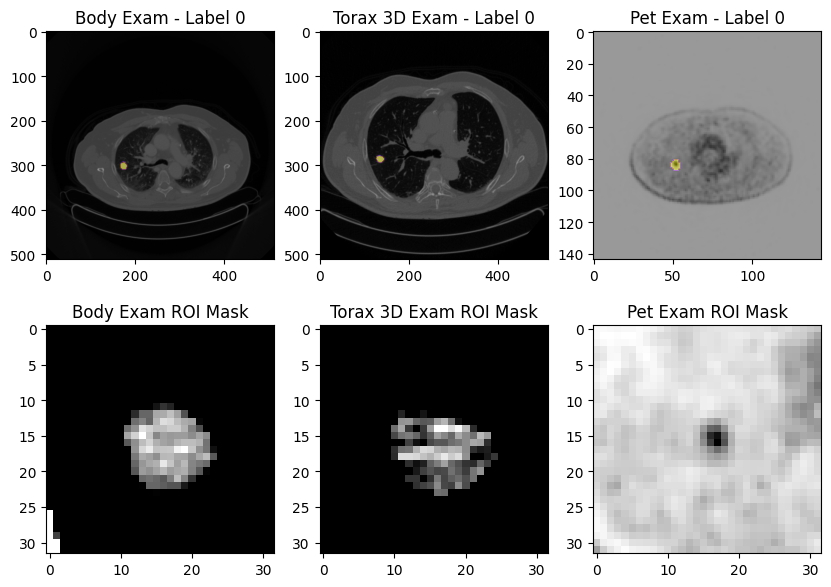

In [5]:
# se cargan los conjuntos de datos de santa maria
santamaria_body_dataset, santamaria_body_info = tfds.load('santa_maria_dataset/body', with_info=True)
santamaria_torax_dataset, santamaria_torax_info = tfds.load('santa_maria_dataset/torax3d', with_info=True)
santamaria_pet_dataset, santamaria_pet_info = tfds.load('santa_maria_dataset/pet', with_info=True)

# cantidad de pacientes a mostrar, cantidad de ejemplos y función de extraccion de ROI
n_patients = 10
n_samples = 1
roi_fn = roiExtractionSize

visualize_n_samples(n_patients, n_samples, roi_fn, 
                    santamaria_body_dataset, santamaria_body_info, santamaria_torax_dataset, 
                     santamaria_torax_info, santamaria_pet_dataset, santamaria_pet_info)

patient: R01-059


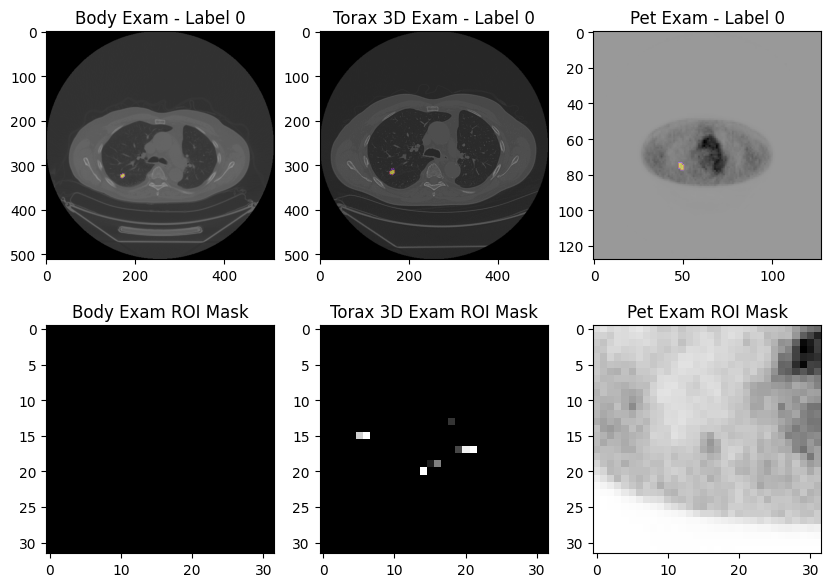

patient: R01-105


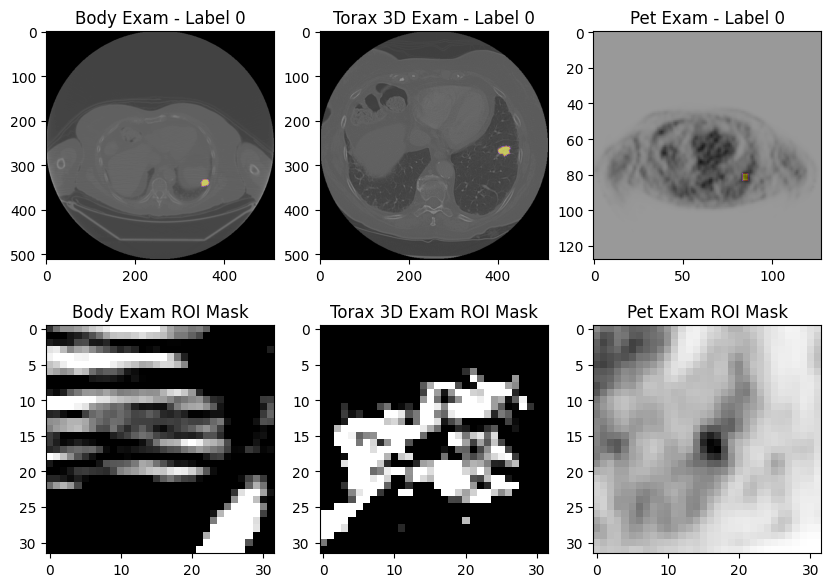

patient: R01-096


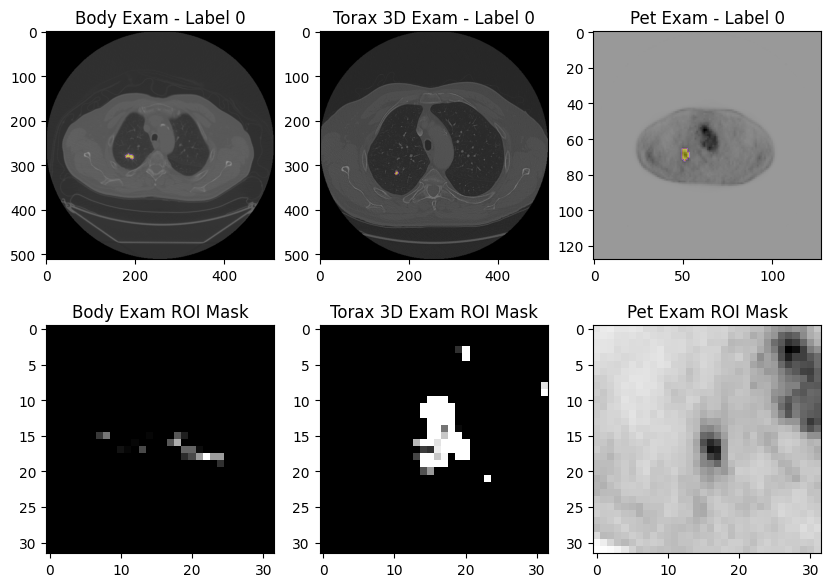

patient: AMC-038


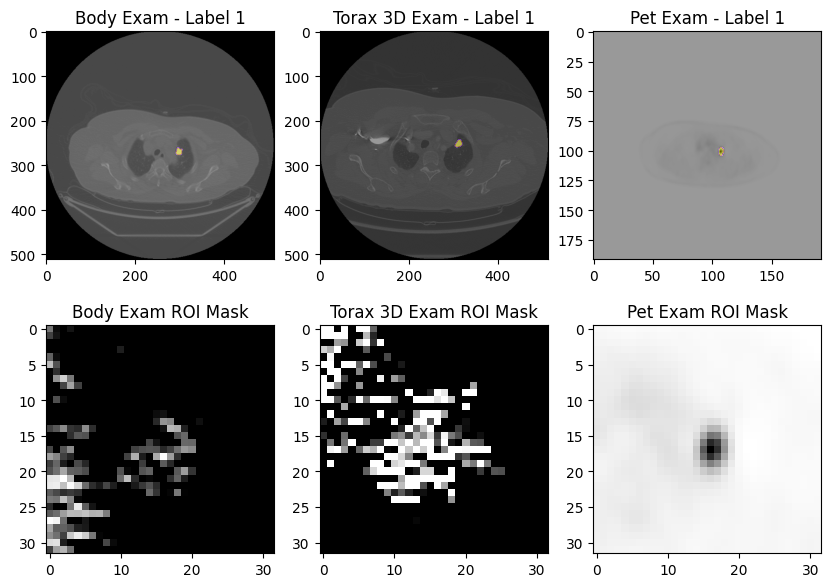

patient: R01-104


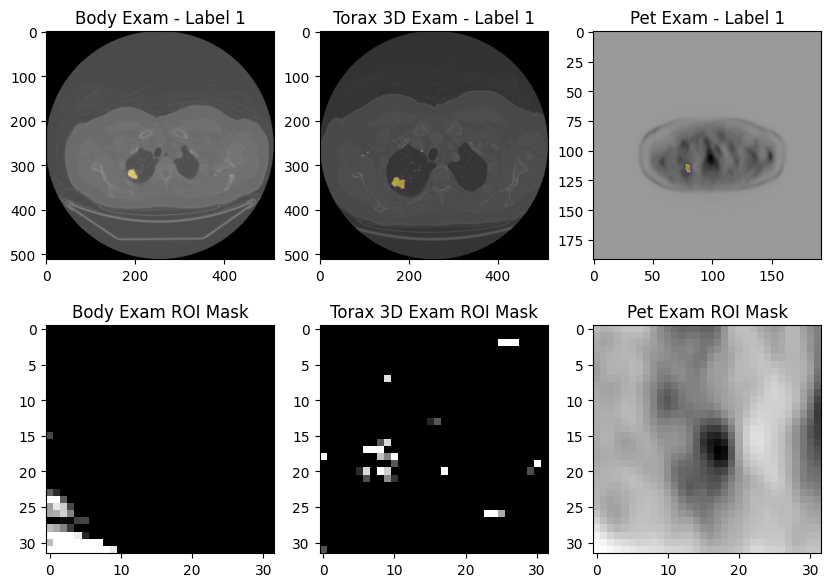

patient: AMC-040


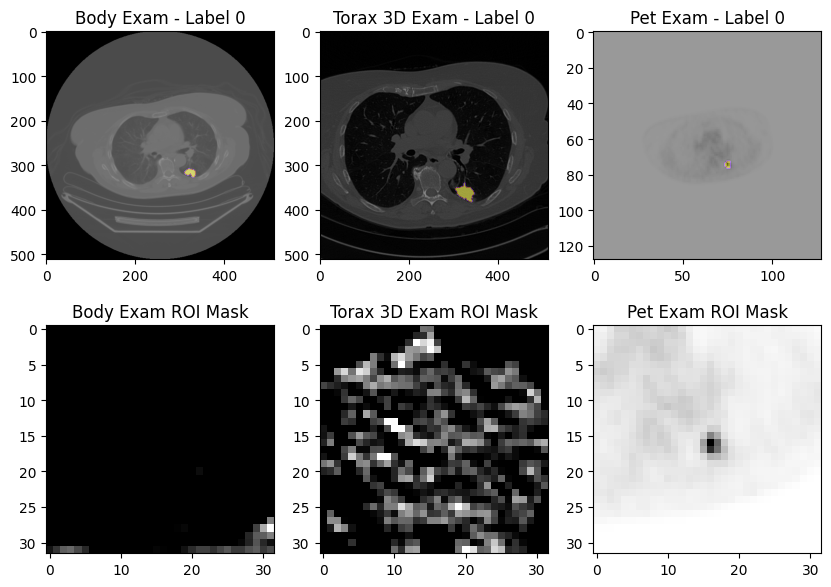

patient: R01-134


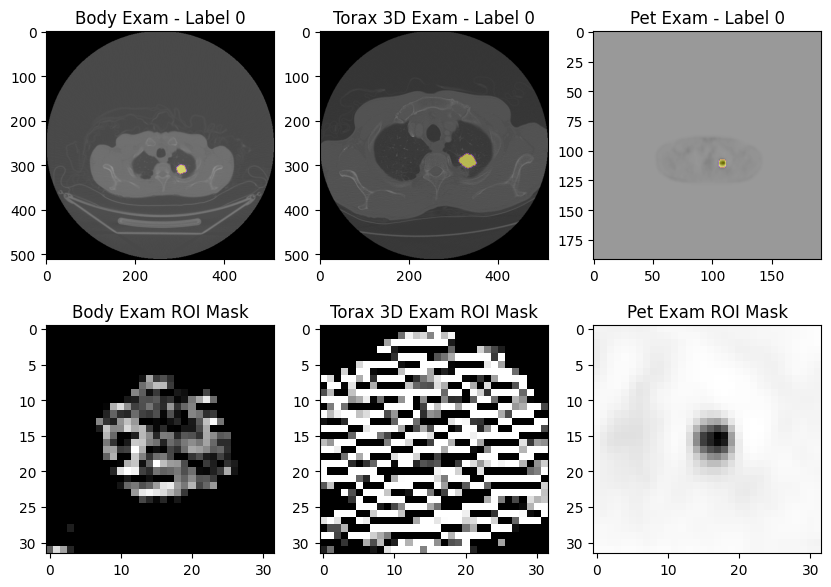

patient: R01-122


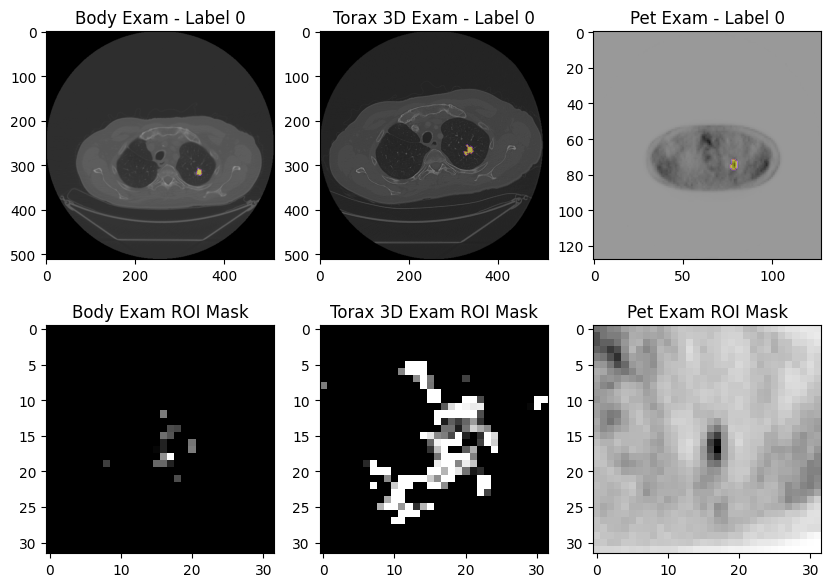

patient: R01-040


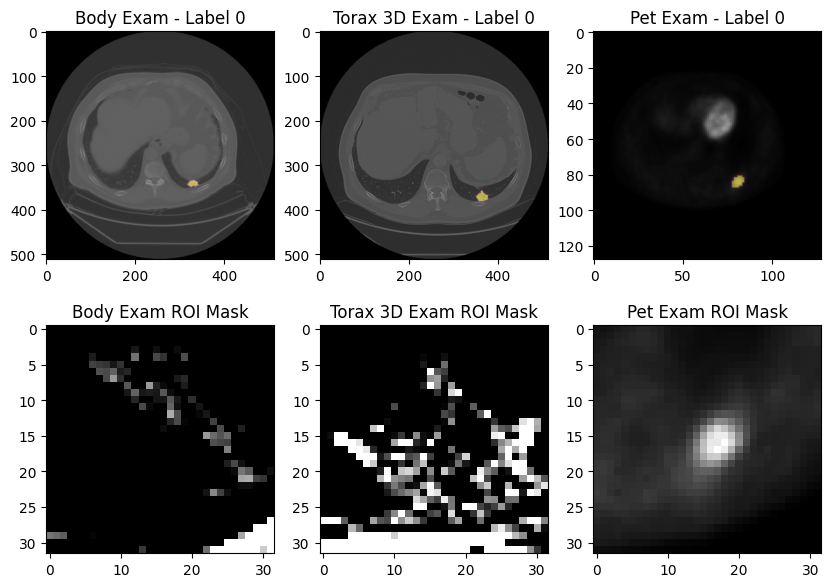

patient: R01-046


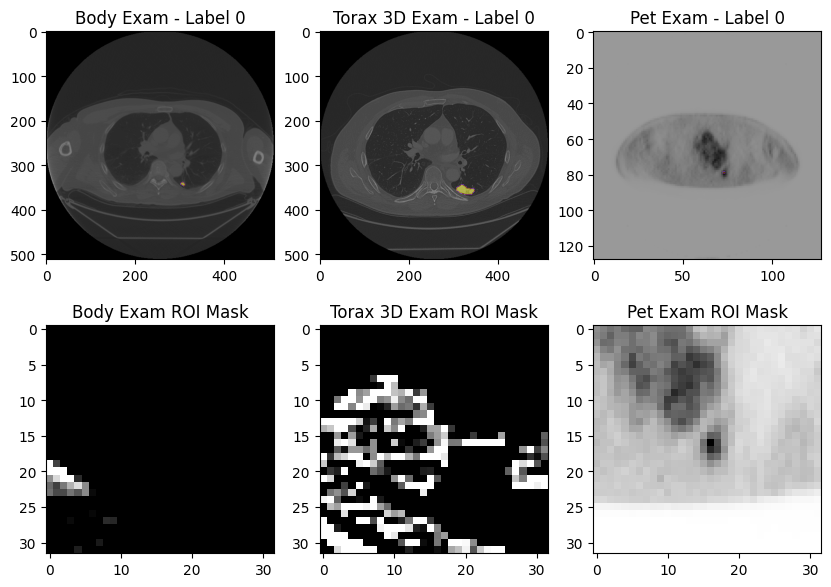

In [6]:
# se cargan los conjuntos de datos de santa maria
stanford_body_dataset, stanford_body_info = tfds.load('stanford_dataset/ct', with_info=True)
stanford_torax_dataset, stanford_torax_info = tfds.load('stanford_dataset/chest_ct', with_info=True)
stanford_pet_dataset, stanford_pet_info = tfds.load('stanford_dataset/pet', with_info=True)

# cantidad de pacientes a mostrar, cantidad de ejemplos y función de extraccion de ROI
n_patients = 10
n_samples = 1
roi_fn = roiExtractionSize

visualize_n_samples(n_patients, n_samples, roi_fn, 
                    stanford_body_dataset, stanford_body_info, stanford_torax_dataset, 
                    stanford_torax_info, stanford_pet_dataset, stanford_pet_info)


In [37]:
def display_sample_images(img, mask, roi, label, cmap_clr='gray'):
    img, mask, roi = img.numpy(), mask.numpy(), roi.numpy()
    
    # Scale the images to uint8 range
    img = ((img - np.min(img)) / (np.max(img) - np.min(img)) * 255).astype(np.uint8)
    mask = (mask * 255).astype(np.uint8) # probablemente cambiar esto, min es o y max es 1
    roi_to_show = ((roi - np.min(roi)) / (np.max(roi) - np.min(roi)) * 255).astype(np.uint8)

    img_pil, mask_pil, roi_to_show = Image.fromarray(img), Image.fromarray(mask), Image.fromarray(roi_to_show)
    
    f, axarr = plt.subplots(1, 2, figsize=(5, 5))
    
    axarr[0].set_title("Exam Image and Mask")
    axarr[0].imshow(img_pil, cmap='gray')
    axarr[0].imshow(mask_pil, cmap='gnuplot', alpha=0.4)
    axarr[1].set_title(f"Extracted ROI - Label: {label.numpy()}")
    axarr[1].imshow(roi_to_show)

    plt.tight_layout()
    plt.show()